In [27]:
# Import necessary libraries for data manipulation, machine learning, and visualization.
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import os
import keras
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Set environment variable to prevent a specific error in certain library versions.
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Set a fixed random seed for reproducibility.
keras.utils.set_random_seed(42)

In [28]:
# Function to fill missing data using MICE imputation.
def fill_missing_data_with_mice_imputer(df: pd.DataFrame):
    mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), imputation_order='ascending')
    df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df), columns=df.columns)
    return df_mice_imputed

In [29]:
# Function to apply one-hot encoding to specified columns.
def hot_encode_columns(original_df, columns):
    original_df = original_df.copy()
    encoded_df = pd.get_dummies(original_df.loc[:, columns])
    original_df.drop(columns, axis=1, inplace=True)
    return pd.concat([original_df, encoded_df], axis=1)

In [30]:
# Function to visualize missing values in a DataFrame.
def show_missing_values(df: pd.DataFrame):
    plt.figure(figsize=(20, 6))
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()

In [31]:
# Load train and test datasets.
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [32]:
# Display DataFrame information.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [33]:
# Drop unnecessary columns.
columns_to_drop = ['Name', 'Cabin', 'Ticket']
train_df.drop(columns_to_drop, axis=1, inplace=True)
test_df.drop(columns_to_drop, axis=1, inplace=True)

In [34]:
# Specify columns to be one-hot encoded.
columns_to_encode = ['Sex', 'Embarked']

In [35]:
# Apply one-hot encoding to the specified columns in train and test DataFrames.
train_df = hot_encode_columns(train_df, columns_to_encode)
test_df = hot_encode_columns(test_df, columns_to_encode)

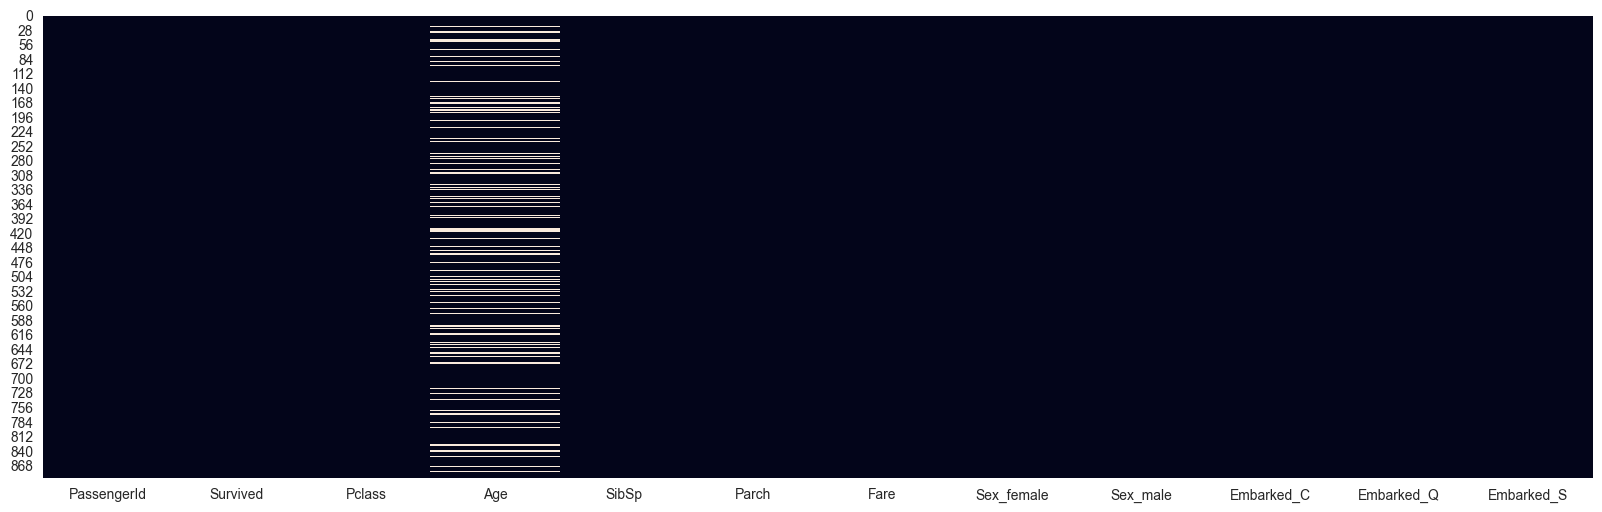

In [36]:
# Show missing values in the DataFrame after encoding.
show_missing_values(train_df)


In [37]:
# Fill missing data using the previously defined MICE imputation function.
train_df = fill_missing_data_with_mice_imputer(train_df)
test_df = fill_missing_data_with_mice_imputer(test_df)


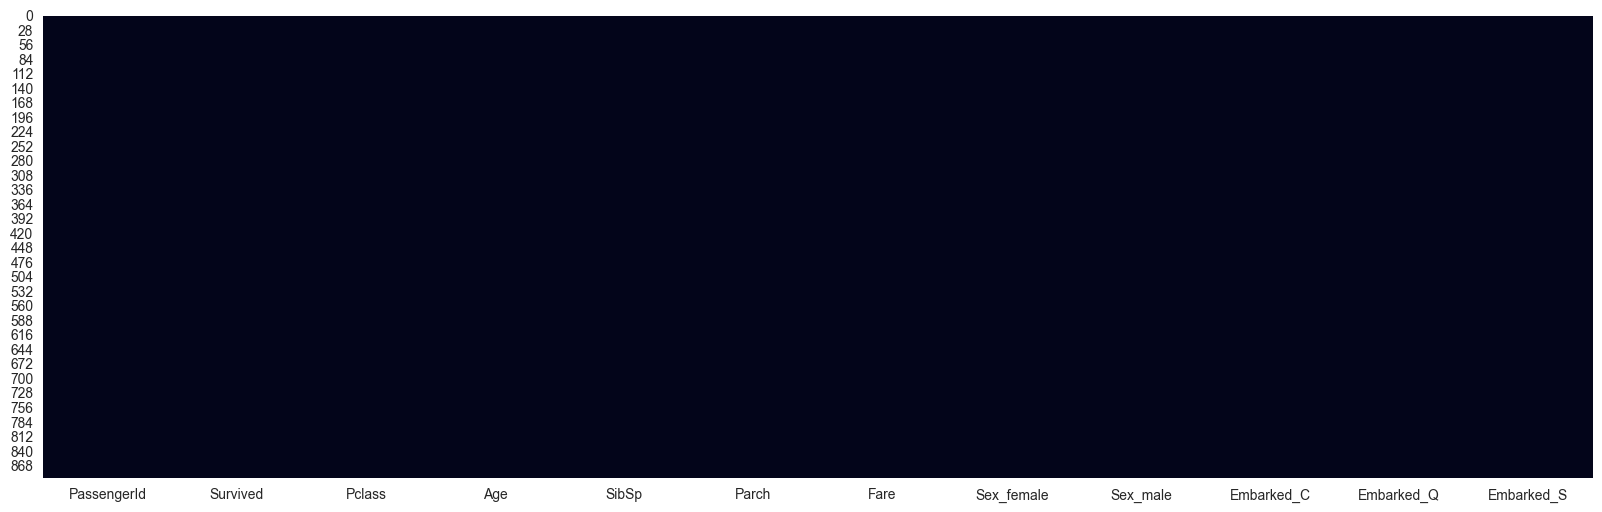

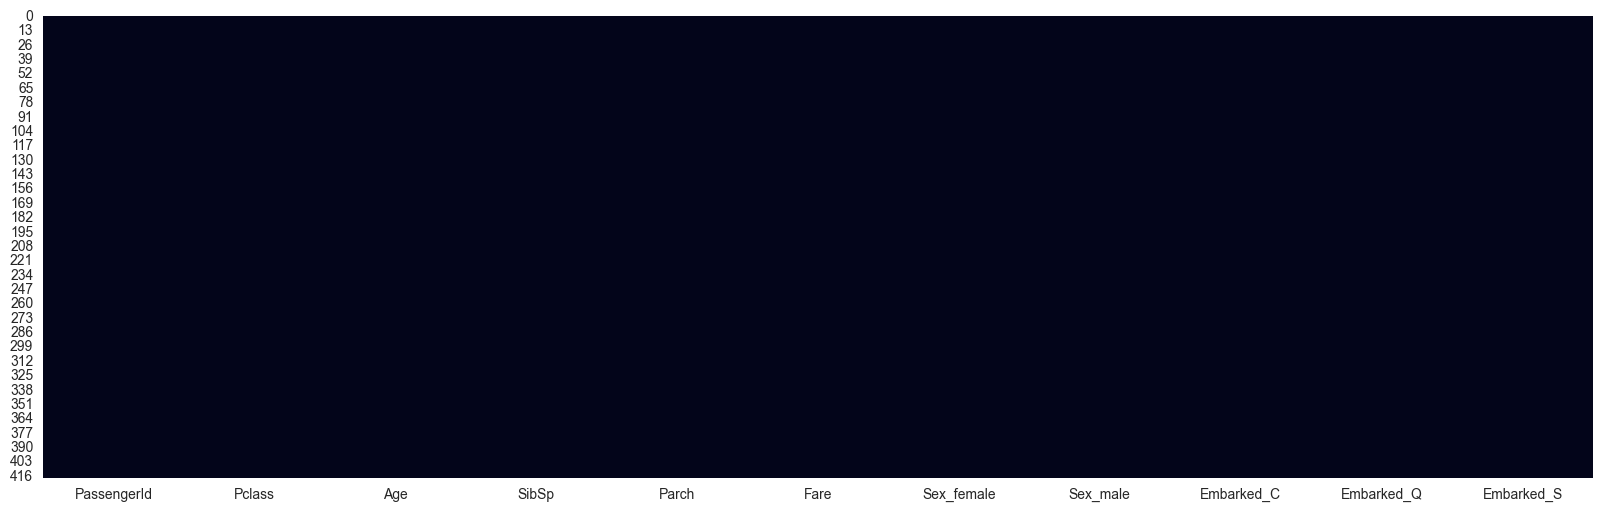

In [38]:
# Show missing values after imputation to ensure all are filled.
show_missing_values(train_df)
show_missing_values(test_df)

In [39]:
# Split the training data into features and target variable.
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

In [40]:
# Split the dataset into training and validation sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
# Define a function to train a neural network model with varying learning rates.
def train_model(learning_rate):
    inputs = keras.layers.Input(shape=(X.shape[1],))
    x = keras.layers.Dense(128, activation='relu')(inputs)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    change_lr = keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.1)
    
    history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, change_lr])
    test_loss, test_acc = model.evaluate(X_test, y_test)
    return history, test_acc, test_loss, model

In [42]:


def plot_results_for_model(hist, test_loss, test_acc, lr):
    """
    Plots the training history of a model, including loss and accuracy, and prints test results.

    Parameters:
    hist (History): The training history object returned by the fit method of a model.
    test_loss (float): The loss of the model on the test dataset.
    test_acc (float): The accuracy of the model on the test dataset.
    lr (float): The learning rate used in training the model.

    The function creates two subplots: one for the loss and one for the accuracy. It also prints
    out the learning rate, test accuracy, and test loss.
    """
    
    # Create a figure with two subplots horizontally aligned
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    # Divider line for better readability in console output
    print('---------------------------------------------------------\n' * 10)

    # Print learning rate, test accuracy, and test loss
    print('Learning rate:', lr)
    print('Test accuracy:', round(test_acc, 3), '%', 'Test loss:', round(test_loss, 3))

    # Plot training and validation loss
    ax[0].plot(hist.history['loss'], label='Model loss')
    ax[0].plot(hist.history['val_loss'], label='Val loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Calculate the number of epochs based on the accuracy history length
    epochs = len(hist.history['accuracy'])
    epochs_range = range(1, epochs + 1)

    # Plot training and validation accuracy
    ax[1].plot(epochs_range, hist.history['accuracy'][:epochs], label='Model accuracy')
    ax[1].plot(epochs_range, hist.history['val_accuracy'][:epochs], label='Val accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0, 1)  # Set the y-axis limit to range from 0 to 1
    ax[1].legend()

    # Display the plot
    plt.show()


In [43]:
def generate_results(model_results):
    highest_score = {}
    for model_lr, model_values in model_results.items():
        m_acc = model_values['accuracy']
        m_hist = model_values['history']
        m_loss = model_values['loss']
        model_obj = model_values['model']
       
        print(model_values)
        if 1.0 > m_acc > highest_score.get('accuracy',0) :
            highest_score =model_values
            highest_score['lr'] = model_lr
        plot_results_for_model(m_hist ,m_loss ,m_acc , model_lr)
   
        
    return highest_score
            

In [44]:
# Train and evaluate models for different learning rates
learning_rates = [0.0001, 0.001, 0.01, 0.1]

Epoch 1/1000
23/23 [==============================] - 0s 9ms/step - loss: 16.3998 - accuracy: 0.3764 - val_loss: 6.8437 - val_accuracy: 0.4134 - lr: 1.0000e-04
Epoch 2/1000
23/23 [==============================] - 0s 3ms/step - loss: 3.0936 - accuracy: 0.4579 - val_loss: 2.0517 - val_accuracy: 0.4804 - lr: 1.0000e-04
Epoch 3/1000
23/23 [==============================] - 0s 3ms/step - loss: 1.7620 - accuracy: 0.3624 - val_loss: 1.2945 - val_accuracy: 0.4302 - lr: 1.0000e-04
Epoch 4/1000
23/23 [==============================] - 0s 3ms/step - loss: 1.0562 - accuracy: 0.4747 - val_loss: 0.7453 - val_accuracy: 0.5698 - lr: 1.0000e-04
Epoch 5/1000
23/23 [==============================] - 0s 3ms/step - loss: 0.7147 - accuracy: 0.6096 - val_loss: 0.6434 - val_accuracy: 0.6536 - lr: 1.0000e-04
Epoch 6/1000
23/23 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.6404 - val_loss: 0.5862 - val_accuracy: 0.6983 - lr: 1.0000e-04
Epoch 7/1000
23/23 [=========================

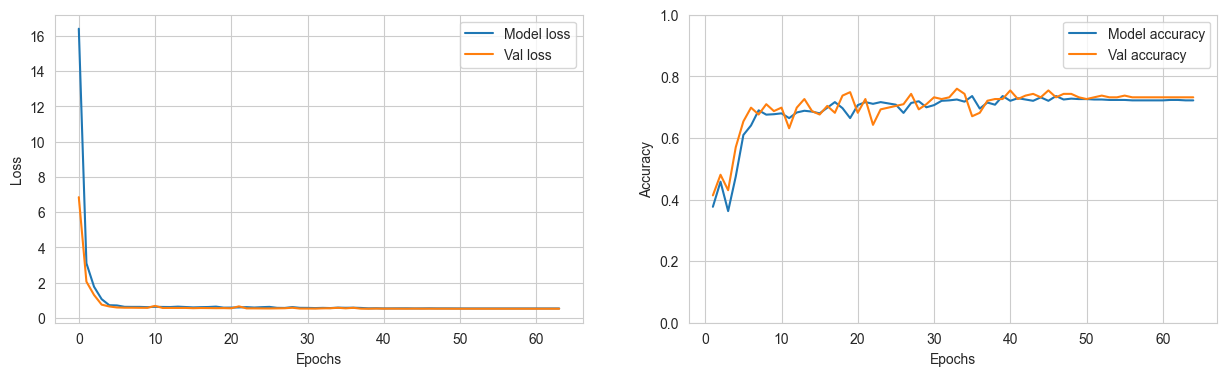

{'accuracy': 0.7932960987091064, 'loss': 0.4642687737941742, 'history': <keras.callbacks.History object at 0x000001B4C00C3A00>, 'model': <keras.engine.functional.Functional object at 0x000001B4BF9B0E80>}
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------

Learning rate: 0.001
Test accuracy: 0.793 % Test loss: 0.464


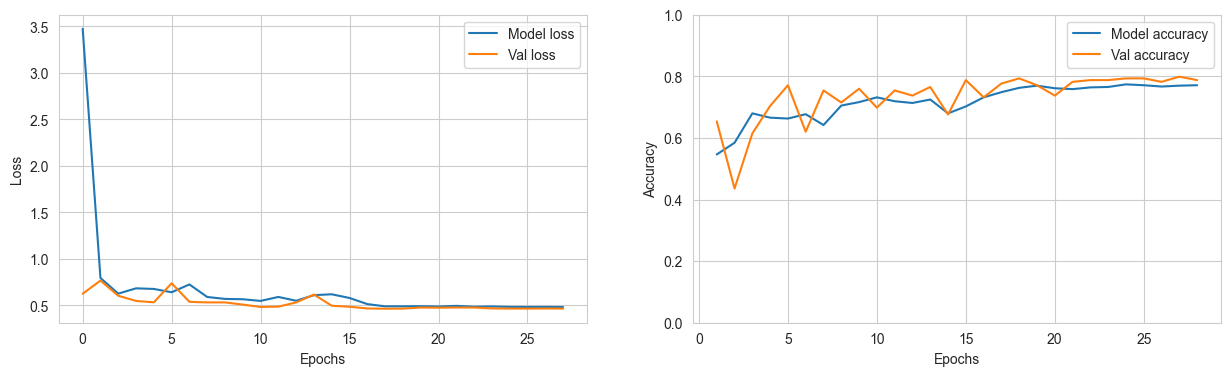

{'accuracy': 0.7988826632499695, 'loss': 0.4496096670627594, 'history': <keras.callbacks.History object at 0x000001B4BFA37B20>, 'model': <keras.engine.functional.Functional object at 0x000001B4BFA37C40>}
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------

Learning rate: 0.01
Test accuracy: 0.799 % Test loss: 0.45


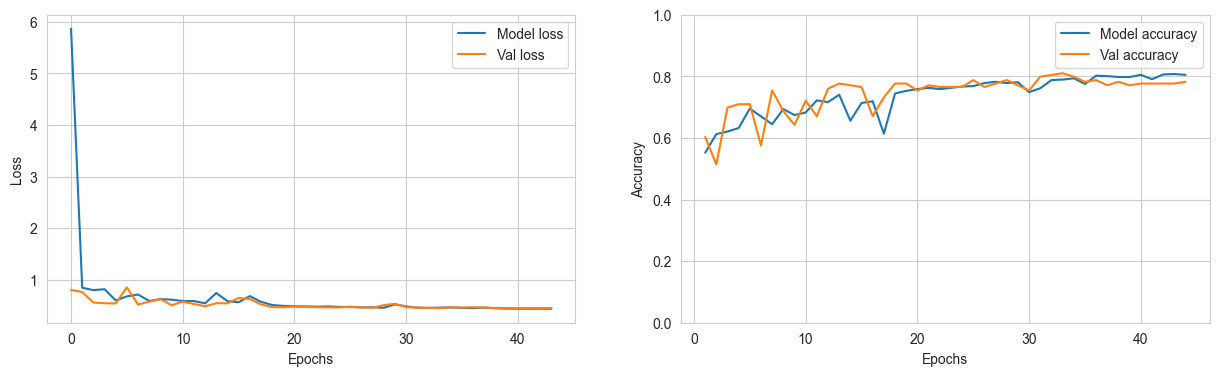

{'accuracy': 0.5865921974182129, 'loss': 0.6793597340583801, 'history': <keras.callbacks.History object at 0x000001B4C006F760>, 'model': <keras.engine.functional.Functional object at 0x000001B4C0080FD0>}
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------

Learning rate: 0.1
Test accuracy: 0.587 % Test loss: 0.679


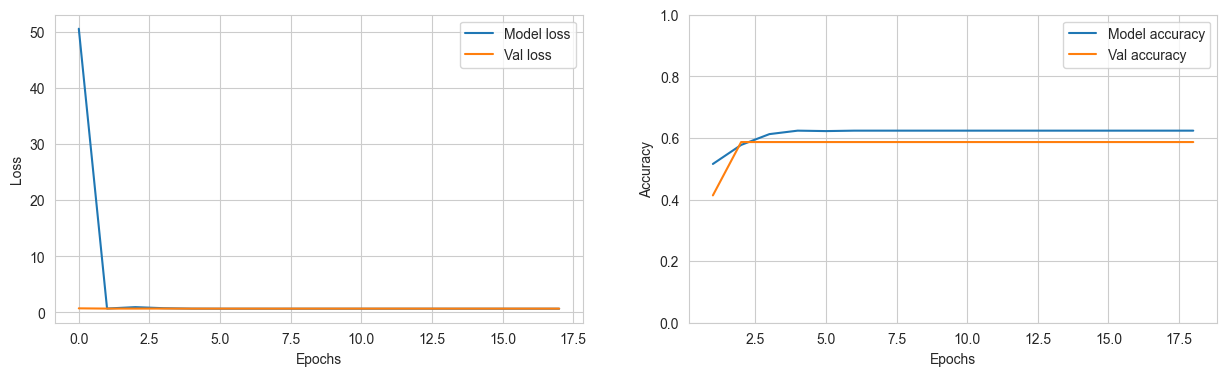

{'accuracy': 0.7988826632499695,
 'loss': 0.4496096670627594,
 'history': <keras.callbacks.History at 0x1b4bfa37b20>,
 'model': <keras.engine.functional.Functional at 0x1b4bfa37c40>,
 'lr': 0.01}

In [45]:
# Train and evaluate the model for different learning rates
results = {}
for lr in learning_rates:
    history, accuracy , loss,model  = train_model(lr  )
    results[lr] = {'accuracy' :accuracy,
                   'loss':loss,
                   'history':history,
                   'model':model}
        
   
    
    
generate_results(results)
        
   
    
    

In [46]:

results


{0.0001: {'accuracy': 0.7318435907363892,
  'loss': 0.5149062871932983,
  'history': <keras.callbacks.History at 0x1b4b8da4b20>,
  'model': <keras.engine.functional.Functional at 0x1b4b8e010a0>,
  'lr': 0.0001},
 0.001: {'accuracy': 0.7932960987091064,
  'loss': 0.4642687737941742,
  'history': <keras.callbacks.History at 0x1b4c00c3a00>,
  'model': <keras.engine.functional.Functional at 0x1b4bf9b0e80>,
  'lr': 0.001},
 0.01: {'accuracy': 0.7988826632499695,
  'loss': 0.4496096670627594,
  'history': <keras.callbacks.History at 0x1b4bfa37b20>,
  'model': <keras.engine.functional.Functional at 0x1b4bfa37c40>,
  'lr': 0.01},
 0.1: {'accuracy': 0.5865921974182129,
  'loss': 0.6793597340583801,
  'history': <keras.callbacks.History at 0x1b4c006f760>,
  'model': <keras.engine.functional.Functional at 0x1b4c0080fd0>}}

In [47]:
# Show best accuracies


def show_best_accuracy(res):
    best_model = None
    print("Results:")
    for lr, vals in res.items():
        print(f'Learning Rate {lr}: Test Accuracy {vals["accuracy"]}')
        
    highest_accuracy = max([vals["accuracy"] for vals in res.values()])
    highest_accuracy_lr = [lr for lr, vals in res.items() if vals["accuracy"] == highest_accuracy][0]
    print(res[highest_accuracy_lr])
    best_model = res[highest_accuracy_lr]['model']
    print(f'Highest  Accuracy: {highest_accuracy} (Learning Rate {highest_accuracy_lr})')
    return best_model

In [48]:
# Predict survival using the best model and prepare for submission.
best_model = show_best_accuracy(results)

Results:
Learning Rate 0.0001: Test Accuracy 0.7318435907363892
Learning Rate 0.001: Test Accuracy 0.7932960987091064
Learning Rate 0.01: Test Accuracy 0.7988826632499695
Learning Rate 0.1: Test Accuracy 0.5865921974182129
{'accuracy': 0.7988826632499695, 'loss': 0.4496096670627594, 'history': <keras.callbacks.History object at 0x000001B4BFA37B20>, 'model': <keras.engine.functional.Functional object at 0x000001B4BFA37C40>, 'lr': 0.01}
Highest  Accuracy: 0.7988826632499695 (Learning Rate 0.01)


In [49]:
submission_preds = best_model.predict(test_df)

14/14 [==============================] - 0s 1ms/step


In [50]:
submissions_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived':submission_preds.reshape(-1) })

In [51]:

submissions_df['PassengerId']  = submissions_df['PassengerId'].astype('int32')

submissions_df['Survived']  = submissions_df['Survived'].astype('int32')

submissions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int32
 1   Survived     418 non-null    int32
dtypes: int32(2)
memory usage: 3.4 KB


In [52]:
# Save the files
submissions_df.to_csv('./submissions/submission_3.csv', index=False)

### Conclusion for the Third Approach Using Neural Networks with MICE Imputation and Adaptive Learning Rates
This Python software uses advanced data preparation techniques, neural network design, and adaptive learning rate modifications to forecast survival rates on the Titanic dataset. Here's an evaluation of this method:
1. **Data Preprocessing**: 
- **One-Hot Encoding**: Convert key category characteristics ('Sex' and 'Embarked') to a numerical representation suitable for neural networks.
   - **MICE Imputation**: Missing values are handled with Multiple Imputation by Chained Equations (MICE), which uses a Bayesian Ridge estimator to give a more statistically robust imputation than simpler approaches such as mean or median. This method aids in estimating the real distribution of the data.
   - **Feature Reduction**: Columns that are unlikely to influence survival prediction ('Name', 'Cabin', 'Ticket') are deleted, reducing the model's input space and perhaps improving generalization.

2. Model Development: 
    - **Neural Network Architecture**: The script uses a multi-layer perceptron model with three hidden layers. This design was developed to capture complicated non-linear interactions in the data.

   - **Adaptive Learning Rates**: The script uses an adaptive learning rate with early stopping and plateau reduction to guarantee that the model converges optimally without overfitting, making the training process more efficient and perhaps boosting the model's generalization capabilities.

3. **Model Training and Validation**: 
    - **Training with Validation**: A part of the data is allocated for validation to prevent overfitting.
   - **Visual Feedback**: Throughout the training and validation processes, visual feedback is provided on both loss and accuracy measures, which assists in understanding model behavior over epochs.
4. **Evaluating Models and Generating Results**: The script compares several learning rates to see which one produces the best accuracy, guaranteeing that the learning rate is optimized to improve model performance.

   - **Result Generation and Analysis**: It generates findings in a methodical manner, determines the best-performing model, and forecasts test set survival.

5. **Output Preparation**: 
    - **Preparation for Submission**: Predictions are structured to meet competition rules and ready for submission. The script also ensures that all data types are properly prepared for submission.
   - **Output Verification**: The submitted file's structure is checked to verify it adheres to the desired format.

## Overall Evaluation


This strategy combines strong data preparation and powerful machine learning algorithms. The usage of neural networks is ideal for collecting complicated patterns in data, and the adjustable learning rate assures efficient and effective learning. The systematic approach to addressing missing data, encoding categorical variables, and refining model parameters demonstrates a well-planned method for maximizing predictive performance.

The resulting model aims for high accuracy while also ensuring resilience through validation and adaptive learning, making it an effective tool for survival prediction on the Titanic dataset. This method is especially useful in contests like Kaggle, where accuracy and generalization are critical to achieving high rankings.
